<h1>A3I Project - Choreography Planning by Decoupling A* Deterministic Search and Heuristic Computation</h1>
<h4 style="text-align: center">Authors: Lorenzo Balzani, Davide Bombardi</h4>
<p style="text-align: center">
    <a href="mailto:lorenzo.balzani@studio.unibo.it">lorenzo.balzani@studio.unibo.it</a> -
    <a href="mailto:davide.bombardi@studio.unibo.it">davide.bombardi@studio.unibo.it</a>
</p>


<h2>Abstract</h2>
<div class="abstract">
    <p>To Be Written (TBW)</p>
</div>

## Setup
Perform the following steps to setup the environment for running the code in this notebook:
1. Create a file named `secrets.env` in the root directory of the project and add the following lines:
    ```bash
    OPENAI_API_KEY=<your_openai_api_key>
    OPENAI_API_URL=https://api.openai.com
    ```
2. Setup the environment by launching the script `./setup_env.sh` in the terminal. 
3. After activate it with `conda activate a3i`.
4. For installing the ipython kernel, please run `python -m ipykernel install --user --name=a3i`.

In [14]:
%%capture
from dotenv import load_dotenv
import networkx as nx
from itertools import permutations
import matplotlib.pyplot as plt
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import PromptTemplate
import random
from loguru import logger
import re

load_dotenv("secrets.env")
seed = 42
random.seed(seed)

## Position Graph Creation

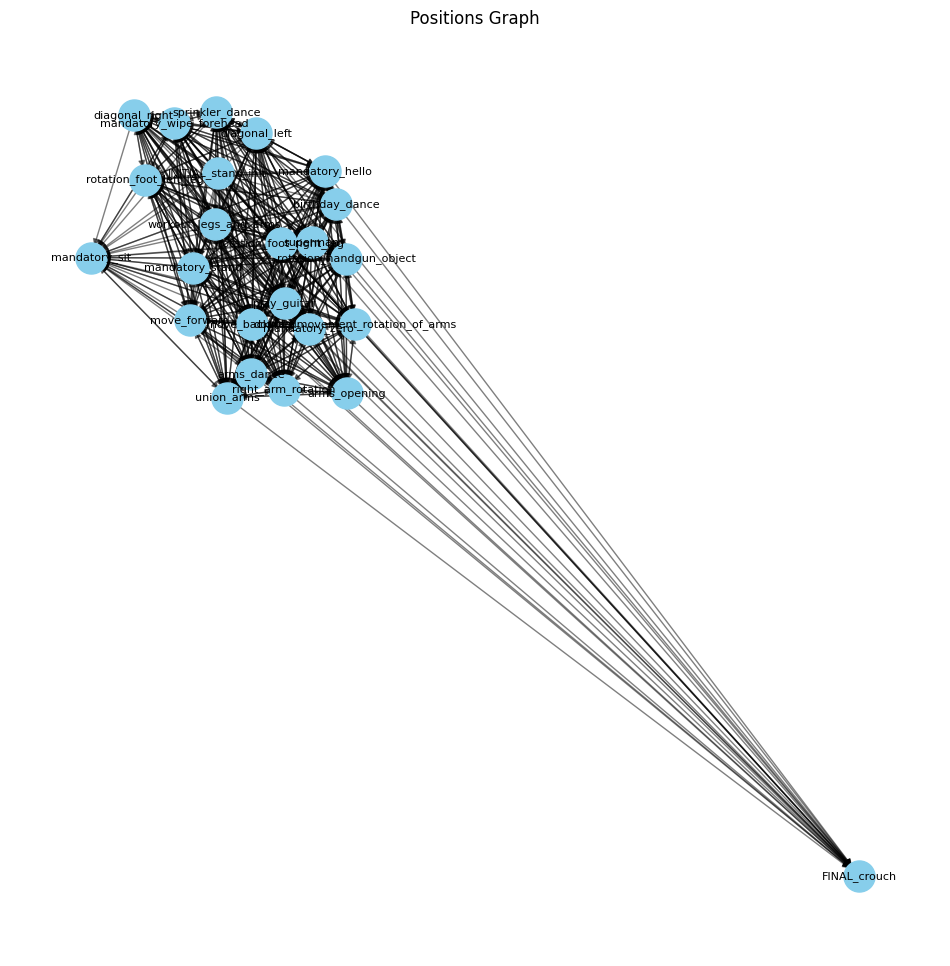

In [27]:
initial_state = 'INITIAL_stand_init'
final_state = 'FINAL_crouch'

# Define the list of nodes
nodes = {initial_state, 'rotation_handgun_object', 'right_arm_rotation', 'double_movement_rotation_of_arms',
         'arms_opening', 'union_arms', 'move_forward', 'move_backward', 'diagonal_left', 'diagonal_right',
         'rotation_foot_left_leg', 'rotation_foot_right_leg', 'play_guitar', 'arms_dance', 'birthday_dance',
         'sprinkler_dance', 'workout_legs_and_arms', 'superman', 'mandatory_sit', 'mandatory_wipe_forehead',
         'mandatory_hello', 'mandatory_stand', 'mandatory_zero', final_state}

# Define the exception nodes for which there are incompatible transitions
exception_nodes = {"mandatory_sit": {'diagonal_right', 'diagonal_left', 'rotation_foot_right_leg', 'rotation_foot_left_leg',
                                     final_state, 'move_backward', 'move_forward', 'play_guitar', 'arms_dance', 'birthday_dance',
                                     'sprinkler_dance', 'workout_legs_and_arms', 'superman'}
}


# Initialize the directed graph, since there are incompatible transitions between some nodes
G = nx.DiGraph()
G.add_nodes_from(nodes)

# Add edges between all pairs of nodes except the specified exceptions
for u, v in permutations(nodes, 2):
    if u == v: # Skip adding self-edges
        continue
    if u == final_state: # Skip adding edges from 'FINAL_crouch' to other nodes, since it is the final node
        continue
    if v == initial_state: # Skip adding edges to 'INITIAL_stand_init', since it is the initial node
        continue
    if u in exception_nodes and v in exception_nodes[u]: # Skip adding edges if the pair is in the exception list
        continue
    G.add_edge(u, v, weight=1)  # Add an edge with a cost of 1

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.title('Positions Graph')
plt.show()

## Graph Statistics

In [3]:
# 1. Number of nodes
num_nodes = G.number_of_nodes()
print(f"1. Number of nodes: {num_nodes}")

# 2. Number of edges
num_edges = G.number_of_edges()
print(f"2. Number of edges: {num_edges}")

# 3. Average in-degree and out-degree
in_degrees = G.in_degree()
out_degrees = G.out_degree()
avg_in_degree = sum(dict(in_degrees).values()) / num_nodes
avg_out_degree = sum(dict(out_degrees).values()) / num_nodes
print(f"3. Average in-degree: {avg_in_degree:.2f}\t--\tAverage out-degree: {avg_out_degree:.2f}")

# 4. Density of the graph
density = nx.density(G)
print(f"4. Graph density: {density:.4f}")

# 5. Is the graph strongly connected?
is_strongly_connected = nx.is_strongly_connected(G)
print(f"5. Is the graph strongly connected? {is_strongly_connected}")

# 6. Number of strongly connected components
num_scc = nx.number_strongly_connected_components(G)
print(f"6. Number of strongly connected components: {num_scc}")

# 7. Average clustering coefficient
# For DiGraph, we use the directed version of clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"7. Average clustering coefficient: {avg_clustering:.4f}")

# 8. Top 3 nodes by PageRank
pagerank = nx.pagerank(G)
top_3_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:3]
print("8. Top 3 nodes by PageRank:")
for node, pr in top_3_pagerank:
    print(f"  {node}: {pr:.4f}")

# 9. In-degree and out-degree of 'mandatory_sit'
in_degree_mandatory_sit = G.in_degree('mandatory_sit')
out_degree_mandatory_sit = G.out_degree('mandatory_sit')
print(f"9. 'mandatory_sit' in-degree: {in_degree_mandatory_sit}\t--\tout-degree: {out_degree_mandatory_sit}")

# 10. Average shortest path length (if the graph is strongly connected)
if is_strongly_connected:
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    print(f"10. Average shortest path length: {avg_shortest_path_length:.4f}")
else:
    print("10. Graph is not strongly connected; average shortest path length not defined.")

# 11. Number of nodes with zero in-degree (sources)
zero_in_degree = [n for n, d in G.in_degree() if d == 0]
print(f"11. Number of nodes with zero in-degree (sources): {len(zero_in_degree)}")

# 12. Number of nodes with zero out-degree (sinks)
zero_out_degree = [n for n, d in G.out_degree() if d == 0]
print(f"12. Number of nodes with zero out-degree (sinks): {len(zero_out_degree)}")

# 13. Diameter of the graph (if strongly connected)
if is_strongly_connected:
    diameter = nx.diameter(G)
    print(f"13. Diameter of the graph: {diameter}")
else:
    print("13. Graph is not strongly connected; diameter not defined.")

# 14. Eccentricity of the initial state (if strongly connected)
if is_strongly_connected:
    eccentricity = nx.eccentricity(G, initial_state)
    print(f"14. Eccentricity of '{initial_state}': {eccentricity}")
else:
    print("14. Graph is not strongly connected; eccentricity not defined.")

1. Number of nodes: 24
2. Number of edges: 494
3. Average in-degree: 20.58	--	Average out-degree: 20.58
4. Graph density: 0.8949
5. Is the graph strongly connected? False
6. Number of strongly connected components: 3
7. Average clustering coefficient: 0.9365
8. Top 3 nodes by PageRank:
  arms_opening: 0.0454
  double_movement_rotation_of_arms: 0.0454
  right_arm_rotation: 0.0454
9. 'mandatory_sit' in-degree: 22	--	out-degree: 9
10. Graph is not strongly connected; average shortest path length not defined.
11. Number of nodes with zero in-degree (sources): 1
12. Number of nodes with zero out-degree (sinks): 1
13. Graph is not strongly connected; diameter not defined.
14. Graph is not strongly connected; eccentricity not defined.


## Graph Waypoints definition

In [5]:
llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    temperature=0,
    verbose=True,
)

# Define a prompt template for getting waypoints
waypoint_prompt = PromptTemplate(
    input_variables=['initial_state', 'final_state', 'positions'],
    template="""
    Given the initial state {initial_state} and the final state {final_state}, output a **strictly comma-separated list** of positions from the available ones that create a very cool, elegant and creative movement sequence. Include initial and final state. Do not include any other text in the output, and format the list exactly as: `position1, position2, position3`.
    
    # POSITIONS
    {positions}
    """
)

# Create an LLMChain for waypoints
waypoint_chain = waypoint_prompt | llm

# Define the available positions as the union of all the nodes except the initial and final states
available_positions = list(nodes - {initial_state, final_state})
random.shuffle(available_positions)

# Run the chain
result = waypoint_chain.invoke({"initial_state": initial_state, "final_state": final_state, "positions": available_positions})

# Extract the comma-separated list using regex
waypoints = re.findall(r'\b\w+(?:, \w+)*\b', result.content)
print(f"Waypoints sequence: {waypoints}")

Waypoints sequence: ['INITIAL_stand_init', 'arms_opening', 'superman', 'rotation_foot_right_leg', 'mandatory_sit', 'FINAL_crouch']


## A* Search Algorithm between waypoints
### Herustic definition
Should receive:
1. Current state, i.e. made of the sequence of positions already visited + the current position
2. The next waypoint to reach
3. max_coolness_score

Evaluate the current state with respect to the goal of reaching the next waypoint in the coolest way possible.

In [35]:
heuristic_prompt = PromptTemplate(
    input_variables=['current_node', 'goal_node', 'max_coolness_score'],
    template="""
        You are an expert choreographer evaluating dance sequences.
        
        - Each node represents a dance move or position.
        - Transitions between moves can be more or less "cool" from a human perspective.
        - Coolness scores range from 0 to {max_coolness_score}, where higher scores mean cooler transitions.
        
        Your task is to evaluate the coolness of transitioning from the current node "{current_node}" to the goal node "{goal_node}". Consider how impressive, engaging, or visually appealing this transition would be to an audience.
        
        **Important Guidelines:**
        
        1. **Evaluation Criteria**: Base your evaluation on creativity, flow, and audience appeal.
        
        2. **Consistency**: Ensure that similar transitions receive similar scores.
        
        3. **Numerical Output**: Provide only a single numerical value representing the coolness score between 0 and {max_coolness_score}, and nothing else.
        
        **Now, please provide the coolness score for transitioning from "{current_node}" to "{goal_node}". Remember to adhere strictly to the guidelines.**
        """
        )

In [36]:
heuristic_cache = {}

def estimate_coolness_to_goal_llm(current_node, goal_node, max_coolness_score):
    """
    Estimate the coolness of transitioning from the current node to the goal node using the LLM.

    Parameters:
    - current_node (str): The name of the current node.
    - goal_node (str): The name of the goal node.
    - max_coolness_score (float): The maximum possible coolness score.

    Returns:
    - coolness_score (float): The estimated coolness score for transitioning to the goal node.
    """
    # Check if the coolness value is already computed and cached
    if (current_node, goal_node) in heuristic_cache:
        return heuristic_cache[(current_node, goal_node)]

    # Prepare the inputs for the LLM prompt
    prompt_inputs = {
        'current_node': current_node,
        'goal_node': goal_node,
        'max_coolness_score': max_coolness_score
    }

    # Call the LLM to get the coolness score
    response = (heuristic_prompt | llm).invoke(prompt_inputs).content

    # Extract and process the response
    try:
        coolness_score = float(response.strip())
        # Ensure the score is within bounds
        if coolness_score < 0:
            coolness_score = 0
        elif coolness_score > max_coolness_score:
            coolness_score = max_coolness_score
    except ValueError:
        # Default to a neutral coolness score if parsing fails
        coolness_score = max_coolness_score / 2

    # Store the coolness score in the cache
    heuristic_cache[(current_node, goal_node)] = coolness_score

    return coolness_score

In [37]:
max_coolness = 10  # Assuming coolness scores range from 0 to 10

def heuristic(node1, node2):
    # Get the coolness score from the LLM
    current_state = complete_path + [node1]
    coolness_score = estimate_coolness_to_goal_llm(node1, node2, max_coolness_score=max_coolness)
    print(f"Coolness percieved from {node1} to {node2}: {coolness_score} (higher is better)")
    # Invert the coolness score to get the heuristic value
    heuristic_value = max_coolness - coolness_score
    return heuristic_value

In [38]:
# Check if initial and final states are in the waypoints
if initial_state not in waypoints:
    waypoints = [initial_state] + waypoints
if final_state not in waypoints:
    waypoints.append(final_state)

# A* path planning between waypoints
complete_path = []

for i in range(len(waypoints) - 1): # Iterate over pairs of waypoints
    print(f"\nFinding path between {waypoints[i]} and {waypoints[i + 1]}")
    start = waypoints[i]
    goal = waypoints[i + 1]
    try:
        # Perform A* search with the LLM heuristic
        path_segment = nx.astar_path(G, start, goal, heuristic=heuristic, weight='weight')
        # Exclude the start node to prevent duplication
        path_segment = path_segment[1:] if i > 0 else path_segment
        complete_path.extend(path_segment)
    except nx.NetworkXNoPath:
        print(f"No path found between {start} and {goal}")
        complete_path = None
        break
    print(f"Updated complete path: {complete_path}")


Finding path between INITIAL_stand_init and arms_opening
Coolness percieved from arms_opening to arms_opening: 5.0 (higher is better)
Coolness percieved from move_forward to arms_opening: 7.0 (higher is better)
Coolness percieved from arms_dance to arms_opening: 7.0 (higher is better)
Coolness percieved from mandatory_sit to arms_opening: 7.0 (higher is better)
Coolness percieved from play_guitar to arms_opening: 7.0 (higher is better)
Coolness percieved from double_movement_rotation_of_arms to arms_opening: 7.0 (higher is better)
Coolness percieved from birthday_dance to arms_opening: 7.0 (higher is better)
Coolness percieved from workout_legs_and_arms to arms_opening: 7.0 (higher is better)
Coolness percieved from right_arm_rotation to arms_opening: 7.0 (higher is better)
Coolness percieved from rotation_foot_right_leg to arms_opening: 7.0 (higher is better)
Coolness percieved from mandatory_hello to arms_opening: 7.0 (higher is better)
Coolness percieved from rotation_foot_left_leg

In [33]:
# Output the complete path
if complete_path:
    print(f"Complete Path:\n{complete_path}")
else:
    print("Failed to find a complete path.")

Complete Path:
['INITIAL_stand_init', 'arms_opening', 'superman', 'rotation_foot_right_leg', 'mandatory_sit', 'double_movement_rotation_of_arms', 'FINAL_crouch']
